# Ames, Iowa Market Analysis
##### By: Nick Lomeli

-----
#### The goal of this project is to train a machine learning model on the Ames, Iowa housing data from `train.csv` to make predictions based on the observations in `test.csv`. These predictions need to be stored in a new column within the `test.csv` called `SalePrice`. The final dataset with the predictions will then be uploaded to the corresponding kaggle competetion. For this project, the primary metric being used to determine model performance is Root Mean Squared Error (RMSE).

Data dictionary and additional information can be found at: https://www.kaggle.com/c/dsir-907-project-2/data

-----
---

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import RFE

plt.style.use('ggplot')

-----
### Read in the sample dataset to preview what our final dataframe should look like

In [2]:
sample_df = pd.read_csv('./sample_sub_reg.csv')

In [3]:
sample_df.head(2)

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217


------
## Read in the training and test data

In [4]:
df_train = pd.read_csv('./train.csv')

In [5]:
df_test = pd.read_csv('./test.csv')

----
## Exploratory Data Analysis (EDA)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [8]:
df_train.isna().sum().sum()

11040

In [9]:
df_test.isna().sum().sum()

4705

#### Note that there are missing values in both the training and testing datasets that will need to be addressed. I will be using an Imputer to fill these missing datapoints in order to help the model better perform.

In [10]:
df_train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [11]:
df_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


## Create a Heatmap showing the correlation of each feature *(x variables)* to our target *(y variable)*.

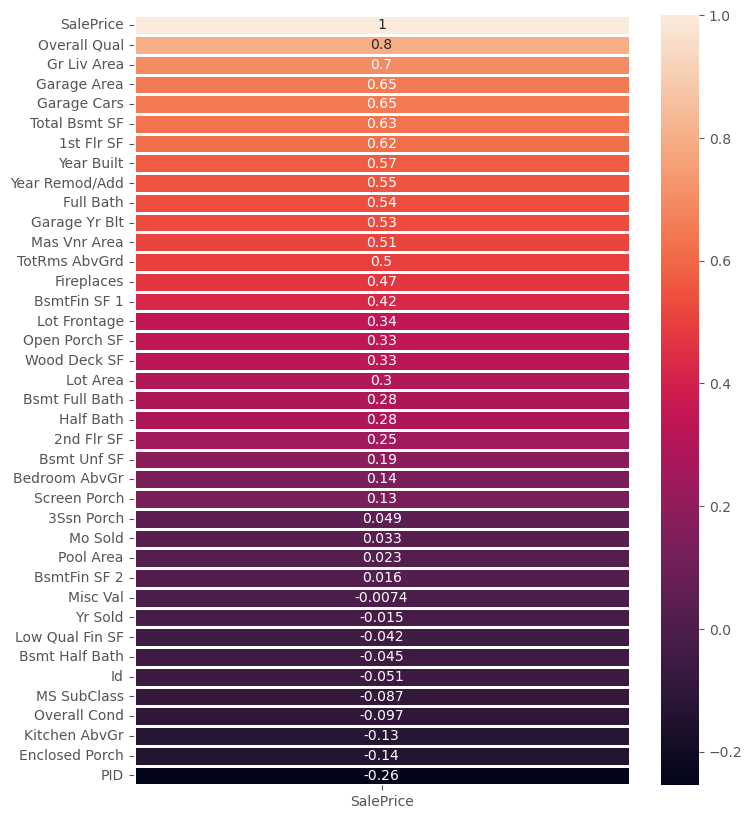

In [12]:
plt.figure(figsize = (8, 10))

sns.heatmap(df_train.corr(numeric_only = True)[['SalePrice']].sort_values(by = 'SalePrice', 
                                                                          ascending = False), 
            annot = True,
            linewidths = 1,
            linecolor = 'white'
);

#### The top 5 features with the strongest correlation to the target are:
1. Overall Quality
2. Gr Living Area (Above Grade (Ground) Living Area)
3. Garage Area
4. Garage Cars
5. Total Basement Sq. Ft.

### Scatterplots showing relationships between a home's Square Feet or Living Area with Sale Price.

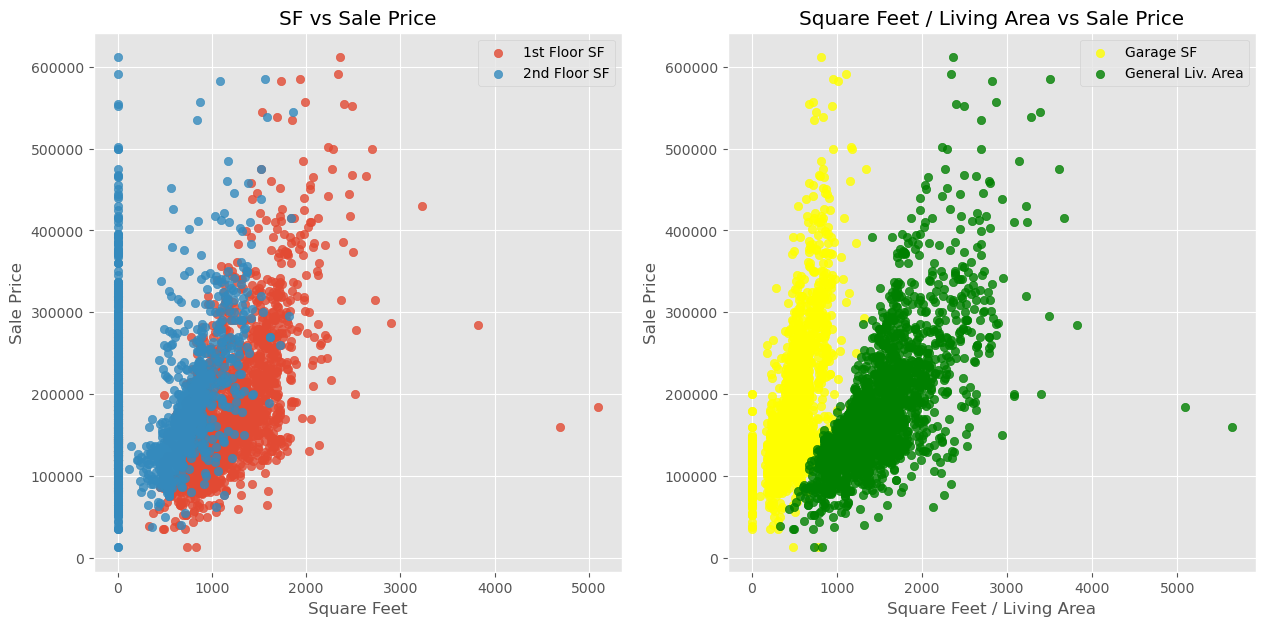

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

ax[0].scatter(df_train['1st Flr SF'], df_train['SalePrice'], alpha = .8, label = '1st Floor SF')
ax[0].scatter(df_train['2nd Flr SF'], df_train['SalePrice'], alpha = .8, label = '2nd Floor SF')
ax[0].legend()
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Square Feet')
ax[0].set_title('SF vs Sale Price')

ax[1].scatter(df_train['Garage Area'], df_train['SalePrice'], alpha = .8, label = 'Garage SF', c = 'yellow')
ax[1].scatter(df_train['Gr Liv Area'], df_train['SalePrice'], alpha = .8, label = 'General Liv. Area', c = 'green')
ax[1].legend()
ax[1].set_title('Square Feet / Living Area vs Sale Price')
ax[1].set_ylabel('Sale Price')
ax[1].set_xlabel('Square Feet / Living Area');

#### There are linear relationships between:
- 1st Floor Square Feet and Sale Price
- 2nd Floor Square Feet and Sale Price
- Garage Square Feet and Sale Price
- General Living Area and Sale Price

This supports our findings above with respect to the heatmap.

----
---

------
# Modeling
- Create X and y
- Train/test split

In [14]:
X, y = df_train.drop(columns = 'SalePrice'), df_train['SalePrice']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

### Baseline / Null model
#### Before modeling, we need to know what our baseline score is. Otherwise it will be impossible to tell whether the model is performing better or worse than a null model would.

In [16]:
null_model = np.full_like(y_test, y.mean())

In [17]:
mean_squared_error(y_test, null_model, squared = False)

81874.29218377204

### Baseline / Null model's RMSE is 81,874.29

-----
## Model 1:

- OneHotEncode all features with object dtypes
- Use KNNImputer to impute missing data
- Use StandardScaler to scale the data
- Use RFE to reduce the number of features we use in our model after OneHotEncoding
- Use Ridge as the estimator for the model to make predictions with

In [18]:
# OneHotEncode features with object dtype using ColumnTransformer
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

### Use GridSearchCV to find the best hyperparamters for Model 1
- Create a pipeline object with the desired transformers and estimator 
- Create a parameter grid to pass to the GridSearchCV object

In [19]:
pipe = make_pipeline(ct,
                     KNNImputer(),
                     StandardScaler(),
                     RFE(estimator = Ridge()),
                     Ridge()
                    )

#### Pipeline paramters

In [20]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x1367f8890>)],
                     verbose_feature_names_out=False)),
  ('knnimputer', KNNImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('ridge', Ridge())],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  <sklearn.compose._column

In [21]:
params = {
    'knnimputer__n_neighbors': [3, 4, 5],
    'rfe__estimator__alpha': [.001, .01],
    'ridge__alpha': [10, 100]
}

In [22]:
gs = GridSearchCV(pipe, params, n_jobs = -1)

In [23]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1367f8890>)],
                                                          verbose_feature_names_out=False)),
                                       ('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'knnimputer__n_neighbors': [3, 4, 5],
                         'rfe__estimator__alpha': [0.001, 0.01],
                         'ridge__alpha': [10, 100]})

In [24]:
gs.score(X_test, y_test)

0.9195299782490955

In [25]:
gs.score(X_train, y_train)

0.9394777361968292

In [26]:
gs.best_params_

{'knnimputer__n_neighbors': 5,
 'rfe__estimator__alpha': 0.001,
 'ridge__alpha': 100}

#### This model is accounting for 90% of the variability that we see in the test data compared to 94% in the training data.

In [27]:
mean_squared_error(y_test, gs.predict(X_test), squared = False)

23187.12892425745

In [28]:
baseline = np.full_like(y_test, y.mean())

In [29]:
mean_squared_error(y_test, baseline, squared = False)

81874.29218377204

In [30]:
gs.best_params_

{'knnimputer__n_neighbors': 5,
 'rfe__estimator__alpha': 0.001,
 'ridge__alpha': 100}

#### Baseline RMSE: 81,874.29
#### Model 1 RMSE: 23,187.12

----
------
----
## Model 2:
- OneHotEncode all features with object dtypes
- Use SimpleImputer to impute missing data
- Use StandardScaler to scale the data
- Use RFE with Ridge as the RFE estimator to reduce the number of features we use in our model after OneHotEncoding
- Use Lasso as the estimator for the model to make predictions with

In [31]:
ct2 = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

In [32]:
pipe2 = make_pipeline(
    ct2,
    SimpleImputer(),
    StandardScaler(),
    RFE(estimator = Ridge()),
    Lasso(max_iter = 2_000_000)
)

In [33]:
pipe2.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x13683fc90>)],
                     verbose_feature_names_out=False)),
  ('simpleimputer', SimpleImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('lasso', Lasso(max_iter=2000000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  <s

In [43]:
params2 = {
    'rfe__estimator__alpha': [1, 3],
    'lasso__alpha': [20, 25]
}

In [44]:
gs2 = GridSearchCV(pipe2, params2, n_jobs = -1)

In [45]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x13683fc90>)],
                                                          verbose_feature_names_out=False)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('lasso', Lasso(max_iter=2000000))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [20, 25],
                         'rfe__estimator__alpha': [1, 3]})

In [46]:
gs2.score(X_test, y_test)

0.9176816965872037

In [47]:
gs2.score(X_train, y_train)

0.9418749986986541

In [48]:
gs2.best_params_

{'lasso__alpha': 25, 'rfe__estimator__alpha': 1}

In [49]:
mean_squared_error(y_test, gs2.predict(X_test), squared = False)

23451.904819540647

#### Baseline RMSE: 81,874.29
#### Model 1 RMSE: 23,187.12
#### Model 2 RMSE: 23,451.90

-----
------
-----
# Model 3
- OneHotEncode all features with object dtypes
- Use KNNImputer to impute missing data 
- Use StandardScaler to scale the data
- Use RFE with Ridge as the RFE estimator to reduce the number of features we use in our model after OneHotEncoding
- Use KNeighborsRegressor as the estimator for the model to make predictions with

In [50]:
ct3 = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

In [51]:
pipe3 = make_pipeline(
    ct3,
    KNNImputer(),
    StandardScaler(),
    RFE(estimator = Ridge()),
    KNeighborsRegressor()
)

In [52]:
pipe3.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x140627c90>)],
                     verbose_feature_names_out=False)),
  ('knnimputer', KNNImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('kneighborsregressor', KNeighborsRegressor())],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                              

In [53]:
params3 = {
    'rfe__estimator__alpha': [100, 150, 200],
    'kneighborsregressor__p': [1, 2]
}
    

In [54]:
gs3 = GridSearchCV(pipe3, params3, n_jobs = -1)

In [55]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x140627c90>)],
                                                          verbose_feature_names_out=False)),
                                       ('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__p': [1, 2],
                         'rfe__estimator__alpha': [100, 150, 200]})

In [56]:
gs3.score(X_test, y_test)

0.818124105814649

In [57]:
gs3.score(X_train, y_train)

0.8868495452094048

In [58]:
gs3.best_params_

{'kneighborsregressor__p': 1, 'rfe__estimator__alpha': 150}

In [59]:
mean_squared_error(y_test, gs3.predict(X_test), squared = False)

34859.20578848703

#### Baseline RMSE: 81,874.29
#### **Model 1 RMSE: 23,187.12**
#### Model 2 RMSE: 23,451.90
#### Model 3 RMSE: 34,859.20

----
----

## Results:
### The best performing model in terms of RMSE was Model 1, which used OneHotEncoder, KNNImputer, StandardScaler, RFE as transformers and Ridge the estimator.
----
------


## Create a DataFrame contaning Model 2's coefficients and their corresponding features

In [60]:
all_cols = gs.best_estimator_.named_steps.columntransformer.get_feature_names_out()

In [61]:
rfe_cols = all_cols[gs.best_estimator_.named_steps.rfe.support_]

In [63]:
coefs = gs.best_estimator_.named_steps.ridge.coef_

In [64]:
len(rfe_cols), len(coefs)

(152, 152)

In [65]:
coef_df = pd.DataFrame(zip(rfe_cols, coefs), columns = ['feature', 'coef']).sort_values('coef', ascending = False)

In [66]:
# Top 5 positive coefficients
coef_df.head()

,feature,coef
138,Gr Liv Area,11932.097483
128,Overall Qual,9060.156872
136,1st Flr SF,7917.968763
135,Total Bsmt SF,7653.547275
137,2nd Flr SF,7569.512075


In [67]:
# Top 5 negative coefficients
coef_df.tail()

,feature,coef
143,Kitchen AbvGr,-2923.164821
125,MS SubClass,-3454.308010
123,Sale Type_WD,-3575.562221
116,Misc Feature_Elev,-11009.936767
40,Roof Matl_ClyTile,-13292.959165


### Interpret some coefficients

- Holding all other variables constant, for every 1 standard deviation increase in Above Grade Living Area (Gr Liv Area), we expect to see an increase of \$11,932.09 in the sale price of a home.
- Holding all else constant, for every 1 STD increase in Overall Quality, we expect to see an increase of \$9,060.15 in the sale price of a home.
- Holding all else constant, for every 1 STD increase in Roof Material Clay Tile, we expect to see a decrease of \$13,292.95 in the sale price of a home.



------
-----
## Create a new DataFrame containing our best model's predictions along with the corresponding observation's `id`

In [68]:
# preview sample dataframe for reference
sample_df.head(2)

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217


In [69]:
#creating a blank DataFrame
final_df = pd.DataFrame()

#creating the Id column using df_test's Id column
final_df['Id'] = df_test['Id']

#create SalePrice column and save model predictions on the test data
final_df['SalePrice'] = gs.predict(df_test)

In [70]:
#check work
final_df.head(3)

,Id,SalePrice
0,2658,119903.009318
1,2718,157092.219548
2,2414,214334.539746


### Export DataFrame with predictions as a csv

In [71]:
final_df.to_csv('./nick_predictions')